In [2]:
# import libriares and indpendies
import numpy as np
import pandas as pd
import math
import pandas_datareader as web
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
path = Path('F-F_Research_Data_5_Factors_2x3_daily.CSV')
ffm_5 = pd.read_csv(path, index_col ='Date', infer_datetime_format=True)
ffm_5.index = pd.DatetimeIndex(ffm_5.index)

In [4]:
df = web.DataReader('AAPL', data_source="yahoo", start= '2010/01/01', end='2020/04/10')

In [5]:
data = pd.concat([df, ffm_5], axis =1 , join ='inner')

In [6]:
data.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Mkt-RF', 'SMB',
       'HML', 'RMW', 'CMA', 'RF'],
      dtype='object')

In [7]:
data = data.reindex(columns =['Mkt-RF', 'SMB', 'HML','RMW', 'CMA', 'RF', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'])

In [8]:
# create a new dataframe with only close column
data = data.filter(['Adj Close'])
#convet the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

2045

In [9]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [10]:
#Creat the training data set
#creat the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into X_train and y_train data set
X_train= []
y_train = []

for i in range (30, len(train_data)):
  X_train.append(train_data[i-30:i,0])   #will contain 30 values. index 0 to 29
  y_train.append(train_data[i,0]) #will conrain 31st value.  index 30
  

In [11]:
#convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_train.shape

(2015, 30, 1)

In [13]:
# Bulid the LSTM model
model = Sequential()
number_of_units = 32
dropout_fraction = 0.2

#layer 1
model.add(LSTM(number_of_units, 
               return_sequences= True, 
               input_shape=(X_train.shape[1],1)))
model.add(Dropout(dropout_fraction))

#layer 2
model.add(LSTM(number_of_units,return_sequences= True))
model.add(Dropout(dropout_fraction))

#layer 3
model.add(LSTM(number_of_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(number_of_units))
model.add(Dense(1))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4352      
_________________________________________________________________
dropout (Dropout)            (None, 30, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

In [15]:
#Complie model
model.compile(optimizer='adam', loss='mean_squared_error')  #loss show how well the model did in training

In [16]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 2015 samples
Epoch 1/10
2015/2015 [==============================] - 51s 26ms/sample - loss: 1.0362e-04
Epoch 2/10
2015/2015 [==============================] - 45s 23ms/sample - loss: 5.6056e-04
Epoch 3/10
2015/2015 [==============================] - 45s 22ms/sample - loss: 5.8072e-04
Epoch 4/10
2015/2015 [==============================] - 43s 21ms/sample - loss: 6.2466e-04
Epoch 5/10
2015/2015 [==============================] - 48s 24ms/sample - loss: 6.9346e-04
Epoch 6/10
2015/2015 [==============================] - 43s 21ms/sample - loss: 7.2198e-04
Epoch 7/10
2015/2015 [==============================] - 43s 21ms/sample - loss: 6.6260e-04
Epoch 8/10
2015/2015 [==============================] - 47s 23ms/sample - loss: 6.9701e-04
Epoch 9/10
2015/2015 [==============================] - 43s 21ms/sample - loss: 6.9690e-04
Epoch 10/10
2015/2015 [==============================] - 47s 23ms/sample - loss: 7.0629e-04


In [26]:
#create the teating data set
#create a new array containing scaled values from index  
test_data = scaled_data[training_data_len - 30:,:]
#Create the data sets X_test and y_test
X_test = []
y_test= dataset[training_data_len:,:]
for i in range(30, len(test_data)):
    X_test.append(test_data[i-30:i,0])


In [27]:
# Convert the data to a numpy array
X_test = np.array(X_test)

In [28]:
# Reshape the data
X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [29]:
#Get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


In [30]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

58.65973867875489

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


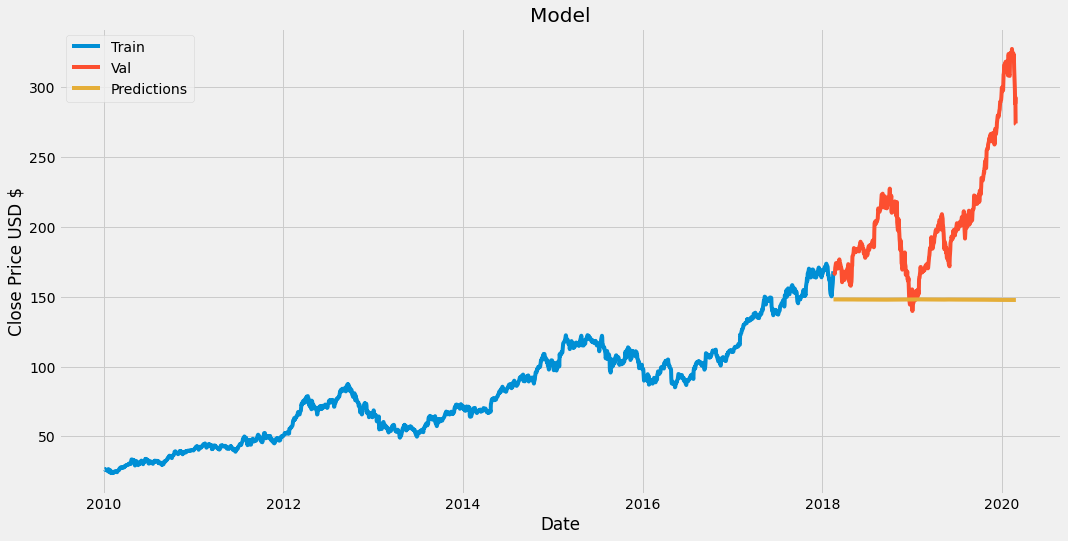

In [31]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visulize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel('Close Price USD $')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.legend(["Train", 'Val','Predictions'])
plt.show()

In [32]:
# show the valid and predicted prices
valid

,Adj Close,Predictions
Date,,
2018-02-16,167.649399,148.028885
2018-02-20,167.085480,148.021866
2018-02-21,166.327103,148.015106
2018-02-22,167.717453,148.009705
2018-02-23,170.634277,148.005600
...,...,...
2020-02-24,298.179993,147.601837
2020-02-25,288.079987,147.606247
2020-02-26,292.649994,147.614700


In [33]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start = '2000/01/01', end= '2020/04/08')
#creat a data frame
new_df = apple_quote.filter(['Adj Close'])
#Get the last 120 day clsoing price values and convert the dataframe to an array
last_60_days = new_df[-30:].values
#Scale the data to ve values between 0 and 1
last_60_scaled = scaler.transform(last_60_days)
#creat an empty list
x_test = []
# Append the past 120 days
x_test.append(last_60_scaled)
# convert the x_test data set to numpy array
x_test = np.array(x_test)
# Reshape
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
# Get the predicted scaled price
pred_price = model.predict(x_test)
#undo the scaling
pred_price= scaler.inverse_transform(pred_price)
print(pred_price)

[[147.7566]]


In [25]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start = '2020/04/06', end= '2020/04/10')
print(apple_quote2['Close'])

Date
2020-04-06    262.470001
2020-04-07    259.429993
2020-04-08    266.070007
2020-04-09    267.989990
Name: Close, dtype: float64
